In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import uproot as up

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

import joblib
import os
import time
from tqdm import tqdm

In [2]:
# Find the filepaths for the root files
sig = "/data/dajiang/2HDM/ML/samples/signal/Medium/"
sig_files = os.listdir(sig)
sig_root_files = [os.path.join(sig,file) for file in sig_files if file.endswith(".root")]

# Make a list of all signal file paths
sig_paths = []
for i in range(len(sig_root_files)):
    sig_paths.append(sig_root_files[i])

# TTbar filepaths
ttbar_paths = "/data/dajiang/2HDM/ML/samples/ttbar/training/user.rjoshi.38019065._000005.output.root"

In [3]:
# Signal Data
start_time = time.time()

# Create dataframe for total signal
sig_df = pd.DataFrame([])

# Add each signal file data to the total signal dataframe
sig_counter = 0
for path in sig_paths:
    sig_counter += 1
    print("File {} of {}: {}".format(sig_counter,len(sig_paths),path)) 

    reco_tree = up.open(path)["reco"]
    reco_arrays = reco_tree.arrays(library = "np")
    reco_df = pd.DataFrame(reco_arrays)
    temp_df = reco_df[(reco_df['nBjets_NOSYS'] > 1) & (reco_df['nBjets_NOSYS'] + reco_df['nLjets_NOSYS'] > 3)] # preselection cuts
    sig_df = pd.concat([sig_df, temp_df]).sample(frac=1).reset_index(drop=True)
    
# ID for signal events
sig_df["Class"] = np.ones(len(sig_df["bjet1_pt_NOSYS"]),dtype=int) # truth label: signal = 1

print()
print("Total number of signal events: {}".format(len(sig_df["bjet1_pt_NOSYS"])))

elapsed_time = time.time() - start_time
print()
print("Time elapsed: {} seconds".format(elapsed_time))

File 1 of 22: /data/dajiang/2HDM/ML/samples/signal/Medium/500_300_mc20a.root
File 2 of 22: /data/dajiang/2HDM/ML/samples/signal/Medium/500_200_mc20d.root
File 3 of 22: /data/dajiang/2HDM/ML/samples/signal/Medium/600_300_mc20a.root
File 4 of 22: /data/dajiang/2HDM/ML/samples/signal/Medium/600_400_mc20d.root
File 5 of 22: /data/dajiang/2HDM/ML/samples/signal/Medium/600_200_mc20a.root
File 6 of 22: /data/dajiang/2HDM/ML/samples/signal/Medium/600_300_mc20d.root
File 7 of 22: /data/dajiang/2HDM/ML/samples/signal/Medium/500_300_mc20d.root
File 8 of 22: /data/dajiang/2HDM/ML/samples/signal/Medium/500_250_mc20d.root
File 9 of 22: /data/dajiang/2HDM/ML/samples/signal/Medium/500_350_mc20d.root
File 10 of 22: /data/dajiang/2HDM/ML/samples/signal/Medium/600_450_mc20a.root
File 11 of 22: /data/dajiang/2HDM/ML/samples/signal/Medium/600_350_mc20a.root
File 12 of 22: /data/dajiang/2HDM/ML/samples/signal/Medium/600_250_mc20a.root
File 13 of 22: /data/dajiang/2HDM/ML/samples/signal/Medium/600_450_mc20d.

In [4]:
sig_df

,el_pt_NOSYS,el_eta,el_phi,el_charge,el_reco_effSF_tight_NOSYS,el_id_effSF_tight_NOSYS,el_isol_effSF_tight_NOSYS,el_IFFClass,el_select_or_NOSYS,el_select_tight_NOSYS,...,chi2_fitted_NOSYS,cos_theta_star_lep_Wlep_NOSYS,cos_theta_star_Hp_A_NOSYS,cos_theta_star_Whad_ljet1_NOSYS,cos_theta_star_Hp_top_NOSYS,cos_theta_star_A_top_NOSYS,met_met_NOSYS,met_phi_NOSYS,met_sumet_NOSYS,Class
0,[],[],[],[],[],[],[],[],[],[],...,5.290503,-0.628645,0.074087,0.360185,-0.226769,0.112258,103694.335938,-0.504511,4.647836e+05,1
1,[],[],[],[],[],[],[],[],[],[],...,21.477625,0.150296,0.711825,-0.659171,-0.390304,0.544800,85060.843750,-0.161048,4.705169e+05,1
2,[69376.84],[0.021846203],[-1.080478],[-1.0],[0.9991316],[1.1664397],[1.0],[2],[1],[1],...,64.731934,-0.387816,-0.548281,0.752454,0.240534,-0.610546,99832.078125,-0.369663,1.181084e+06,1
3,[108568.06],[-1.1190886],[2.8490798],[-1.0],[0.998956],[1.0639733],[1.0],[2],[1],[1],...,211.897507,0.942208,0.516549,-0.136909,0.728362,0.662953,60115.742188,1.733691,4.758513e+05,1
4,[],[],[],[],[],[],[],[],[],[],...,33.339005,-0.419279,0.943190,0.102691,-0.896898,-0.423283,78385.726562,0.505410,5.888001e+05,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132344,[],[],[],[],[],[],[],[],[],[],...,2.984164,0.918768,0.968926,0.727241,0.083354,0.748955,18394.568359,3.002431,3.467596e+05,1
132345,[66782.14],[0.032934375],[0.33957976],[1.0],[0.9991316],[1.1664397],[1.0],[2],[1],[1],...,484.436066,-0.499012,-0.802032,-0.801236,-0.326203,-0.492831,76495.398438,-0.414416,2.181932e+06,1
132346,[],[],[],[],[],[],[],[],[],[],...,30.172901,0.941299,-0.058506,0.260304,0.228946,-0.113355,80392.218750,3.080099,1.061441e+06,1
132347,[],[],[],[],[],[],[],[],[],[],...,11.065263,0.695592,-0.971849,0.677075,-0.223040,-0.914541,37719.656250,-1.556885,4.546745e+05,1


In [5]:
# Load TTBAR data
start_time = time.time()

reco_tree = up.open(ttbar_paths)["reco"]
reco_arrays = reco_tree.arrays(library = "np")
reco_df = pd.DataFrame(reco_arrays)
ttbar_df = reco_df[(reco_df['nBjets_NOSYS'] > 1) & (reco_df['nBjets_NOSYS'] + reco_df['nLjets_NOSYS'] > 3)][:133000] # preselection cuts

# ID for ttbar events
ttbar_df["Class"] = np.zeros(len(ttbar_df["bjet1_pt_NOSYS"]),dtype=int) # truth label: ttbar = 0

print()
print("Total ttbar events: {}".format(len(ttbar_df)))
      
elapsed_time = time.time() - start_time
print()
print("Time elapsed: {} seconds".format(elapsed_time))


Total ttbar events: 133000

Time elapsed: 970.9952907562256 seconds


In [11]:
ttbar_df

,el_pt_NOSYS,el_eta,el_phi,el_charge,el_reco_effSF_tight_NOSYS,el_id_effSF_tight_NOSYS,el_isol_effSF_tight_NOSYS,el_IFFClass,el_select_or_NOSYS,el_select_tight_NOSYS,...,deltaR_Hp_ljet3,deltaR_Hp_ljet4,deltaR_Hp_lepton,deltaR_WfromH_bjet1,deltaR_WfromH_bjet2,deltaR_WfromH_ljet1,deltaR_WfromH_ljet2,deltaR_WfromH_ljet3,deltaR_WfromH_ljet4,deltaR_WfromH_lepton
3,[],[],[],[],[],[],[],[],[],[],...,0.665344,NaN,2.946876,0.961633,2.143996,3.182091,2.111781,2.875506,NaN,0.205961
6,[],[],[],[],[],[],[],[],[],[],...,NaN,NaN,1.089261,4.110092,4.881564,0.032018,4.620029,NaN,NaN,5.067603
8,[88375.63],[-0.8310263],[3.0197783],[1.0],[0.99876326],[0.98294747],[0.9994225],[2],[1],[1],...,0.376471,4.412914,3.169579,1.695655,0.945293,2.739025,0.529788,1.357053,3.899608,2.843545
10,[],[],[],[],[],[],[],[],[],[],...,3.593765,4.409627,3.086706,3.981134,2.167240,1.122898,0.697158,1.431084,7.348214,4.051850
11,[],[],[],[],[],[],[],[],[],[],...,NaN,NaN,2.202307,3.744079,2.609857,1.760280,1.449772,NaN,NaN,3.421584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683944,[62605.363],[0.56613314],[2.4863534],[-1.0],[0.9989055],[0.9957011],[1.0029191],[2],[1],[1],...,NaN,NaN,1.838146,3.005619,1.508852,4.214789,0.652267,NaN,NaN,3.050364
683945,[],[],[],[],[],[],[],[],[],[],...,NaN,NaN,1.545877,2.967668,1.635159,0.000480,3.969950,NaN,NaN,2.213333
683948,[50846.66],[0.88829863],[-2.607048],[1.0],[0.9994848],[0.96461236],[1.0039737],[2],[1],[1],...,NaN,NaN,2.160540,3.201656,2.286909,0.234856,3.538446,NaN,NaN,2.916060
683971,[69913.56],[-0.6934176],[-2.5671802],[1.0],[0.9998951],[0.97553325],[1.0022279],[2],[1],[1],...,2.166492,NaN,1.863225,2.695645,1.385218,2.904779,2.954091,2.568173,NaN,2.920083


In [12]:
start_time = time.time()

# Define vectorized deltaR function
def deltaR(eta1, phi1, eta2, phi2):
    d_eta = eta1 - eta2
    d_phi = (phi1 - phi2 + np.pi) % (2 * np.pi) - np.pi
    return np.sqrt(d_eta**2 + d_phi**2)

# Define function to calculate delta R between two objects
def calculate_deltaR(df, object1_prefix, object2_prefix):
    # Create new column name
    col_name = f'deltaR_{object1_prefix}_{object2_prefix}'
    
    # Select the appropriate columns for eta and phi
    eta1 = df.get(f'{object1_prefix}_eta_NOSYS', df.get(f'{object1_prefix}_eta_fitted_NOSYS', np.nan))
    phi1 = df.get(f'{object1_prefix}_phi_NOSYS', df.get(f'{object1_prefix}_phi_fitted_NOSYS', np.nan))
    eta2 = df.get(f'{object2_prefix}_eta_NOSYS', df.get(f'{object2_prefix}_eta_fitted_NOSYS', np.nan))
    phi2 = df.get(f'{object2_prefix}_phi_NOSYS', df.get(f'{object2_prefix}_phi_fitted_NOSYS', np.nan))
    
    # Handle invalid entries (set delta R to NaN for invalid inputs)
    mask = (eta1 == -999) | (eta2 == -999) | (phi1 == -999) | (phi2 == -999)
    delta_r = deltaR(eta1, phi1, eta2, phi2)
    delta_r[mask] = np.nan
    
    # Assign the computed delta R to the new column
    df[col_name] = delta_r

# Define combinations for sig_df and ttbar_df: 78 total
combinations = [
    ('A', 'Hp'), ('A', 'top'), ('A', 'WfromTop'), ('A', 'WfromH'), ('A', 'Wb_nonTop'),
    ('Hp', 'top'), ('Hp', 'WfromTop'), ('Hp', 'WfromH'), ('Hp', 'Wb_nonTop'),
    ('top', 'WfromTop'), ('top', 'WfromH'), ('top', 'Wb_nonTop'),
    ('WfromTop', 'WfromH'), ('WfromTop', 'Wb_nonTop'),
    ('WfromH', 'Wb_nonTop'),
    ('bjet1', 'bjet2'), ('ljet1', 'ljet2'), ('bjet1', 'ljet1'), ('bjet1', 'ljet2'),
    ('bjet2', 'ljet1'), ('bjet2', 'ljet2'), ('bjet1', 'ljet3'), ('bjet1', 'ljet4'),
    ('bjet2', 'ljet3'), ('bjet2', 'ljet4'), ('ljet1', 'ljet3'), ('ljet1', 'ljet4'),
    ('ljet2', 'ljet3'), ('ljet2', 'ljet4'), ('ljet3', 'ljet4'),
    ('bjet1', 'lepton'), ('bjet2', 'lepton'), ('ljet1', 'lepton'),
    ('ljet2', 'lepton'), ('ljet3', 'lepton'), ('ljet4', 'lepton'),
    ('A', 'bjet1'), ('A', 'bjet2'), ('A', 'ljet1'), ('A', 'ljet2'),
    ('A', 'ljet3'), ('A', 'ljet4'), ('A', 'lepton'),
    ('top', 'bjet1'), ('top', 'bjet2'), ('top', 'ljet1'), ('top', 'ljet2'),
    ('top', 'ljet3'), ('top', 'ljet4'), ('top', 'lepton'),
    ('WfromTop', 'bjet1'), ('WfromTop', 'bjet2'), ('WfromTop', 'ljet1'), ('WfromTop', 'ljet2'),
    ('WfromTop', 'ljet3'), ('WfromTop', 'ljet4'),('WfromTop', 'lepton'), 
    ('Wb_nonTop', 'bjet1'), ('Wb_nonTop', 'bjet2'), ('Wb_nonTop', 'ljet1'), ('Wb_nonTop', 'ljet2'),
    ('Wb_nonTop', 'ljet3'), ('Wb_nonTop', 'ljet4'), ('Wb_nonTop', 'lepton'),
    ('Hp', 'bjet1'), ('Hp', 'bjet2'), ('Hp', 'ljet1'), ('Hp', 'ljet2'),
    ('Hp', 'ljet3'), ('Hp', 'ljet4'), ('Hp', 'lepton'),
    ('WfromH', 'bjet1'), ('WfromH', 'bjet2'), ('WfromH', 'ljet1'), ('WfromH', 'ljet2'),
    ('WfromH', 'ljet3'), ('WfromH', 'ljet4'), ('WfromH', 'lepton'),
]

# Calculate delta Rs
for comb in tqdm(combinations):
    calculate_deltaR(ttbar_df, comb[0], comb[1])
    calculate_deltaR(sig_df, comb[0], comb[1])

elapsed_time = time.time() - start_time
print()
print("Time elapsed: {} seconds".format(elapsed_time))

100%|██████████| 78/78 [00:00<00:00, 115.26it/s]


Time elapsed: 0.6788702011108398 seconds


In [13]:
# Combine signal and ttbar, then shuffle
start_time = time.time()

df = pd.concat([ttbar_df, sig_df]).sample(frac=1).reset_index(drop=True)

# Truth Labels
y_df= df.pop('Class')

elapsed_time = time.time() - start_time
print()
print("Time elapsed: {} seconds".format(elapsed_time))


Time elapsed: 1.3598852157592773 seconds


In [15]:
df["EventNumber"] = range(1,len(df) + 1)
df

,el_pt_NOSYS,el_eta,el_phi,el_charge,el_reco_effSF_tight_NOSYS,el_id_effSF_tight_NOSYS,el_isol_effSF_tight_NOSYS,el_IFFClass,el_select_or_NOSYS,el_select_tight_NOSYS,...,deltaR_Hp_ljet4,deltaR_Hp_lepton,deltaR_WfromH_bjet1,deltaR_WfromH_bjet2,deltaR_WfromH_ljet1,deltaR_WfromH_ljet2,deltaR_WfromH_ljet3,deltaR_WfromH_ljet4,deltaR_WfromH_lepton,EventNumber
0,[],[],[],[],[],[],[],[],[],[],...,NaN,2.251678,4.246667,4.770864,2.701132,1.804552,NaN,NaN,3.787962,1
1,[],[],[],[],[],[],[],[],[],[],...,NaN,0.960439,1.202245,1.142740,2.681165,0.029047,2.108658,NaN,0.566892,2
2,[],[],[],[],[],[],[],[],[],[],...,NaN,1.651405,2.684370,0.427416,3.389940,2.885713,4.896305,NaN,2.513384,3
3,[45350.375],[-0.66545135],[-2.0076554],[1.0],[1.00023],[1.017696],[1.0056862],[2],[1],[1],...,1.344274,1.272568,2.084864,1.923710,4.181394,2.739423,2.878883,1.264359,0.997444,4
4,[],[],[],[],[],[],[],[],[],[],...,2.775968,3.105811,2.017182,2.574259,2.256923,2.129236,0.220030,2.303111,1.954676,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265344,[99252.21],[0.56662285],[-0.9029473],[-1.0],[0.99963707],[1.0509322],[1.0],[2],[1],[1],...,NaN,0.705709,2.956841,3.359282,0.129786,2.843423,1.606224,NaN,2.549923,265345
265345,[58422.63],[-0.67234564],[1.1579348],[1.0],[0.9989797],[1.0802337],[1.0],[2],[1],[1],...,NaN,3.417623,2.712348,2.070812,1.895110,2.087982,NaN,NaN,0.439957,265346
265346,[],[],[],[],[],[],[],[],[],[],...,NaN,3.326250,1.791998,4.205007,0.534668,7.728691,2.292931,NaN,2.644969,265347
265347,[],[],[],[],[],[],[],[],[],[],...,1.563415,2.911076,0.453473,2.658899,3.067661,1.064374,4.794918,1.354869,2.177820,265348


In [16]:
y_df

0         0
1         1
2         1
3         0
4         1
         ..
265344    1
265345    1
265346    0
265347    1
265348    1
Name: Class, Length: 265349, dtype: int64

In [17]:
features = ['deltaR_top_WfromH',
 'WfromH_mass_fitted_NOSYS',
 'MET_phi_NOSYS',
 'deltaR_WfromTop_WfromH',
 'Hp_mass_fitted_NOSYS',
 'deltaR_WfromH_bjet1',
 'deltaR_Hp_WfromH',
 'top_mass_fitted_NOSYS',
 'top_pt_fitted_NOSYS',
 'Hp_pt_fitted_NOSYS',
 'deltaR_top_Wb_nonTop',
 'A_mass_fitted_NOSYS',
 'Wb_nonTop_pt_fitted_NOSYS',
 'lepton_pt_NOSYS',
 'deltaR_bjet1_bjet2',
 'ljet2_pt_NOSYS',
 'ljet1_pt_NOSYS',
 'bjet1_pt_NOSYS',
 'WfromH_pt_fitted_NOSYS',
 'Wb_nonTop_mass_fitted_NOSYS']


"""
['bjet1_pt_NOSYS', 'bjet1_mass_NOSYS', 
'bjet2_pt_NOSYS', 'bjet2_mass_NOSYS', 
'ljet1_pt_NOSYS', 'ljet1_mass_NOSYS',
'ljet2_pt_NOSYS', 'ljet2_mass_NOSYS',
'ljet3_pt_NOSYS', 'ljet3_mass_NOSYS',
'ljet4_pt_NOSYS',  'ljet4_mass_NOSYS',
'lepton_pt_NOSYS',  'lepton_mass_NOSYS',
'A_pt_fitted_NOSYS', 'A_mass_fitted_NOSYS',
'Hp_pt_fitted_NOSYS',  'Hp_mass_fitted_NOSYS',
'top_pt_fitted_NOSYS', 'top_mass_fitted_NOSYS',
'WfromTop_pt_fitted_NOSYS', 'WfromTop_mass_fitted_NOSYS',
'WfromH_pt_fitted_NOSYS', 'WfromH_mass_fitted_NOSYS',
'Wb_nonTop_pt_fitted_NOSYS',  'Wb_nonTop_mass_fitted_NOSYS',
'MET_phi_NOSYS', 'MET_NOSYS',
'cos_theta_star_lep_Wlep_NOSYS',
'cos_theta_star_Hp_A_NOSYS',
'cos_theta_star_Whad_ljet1_NOSYS',
'cos_theta_star_Hp_top_NOSYS',
'cos_theta_star_A_top_NOSYS',            
'deltaR_bjet1_bjet2',
'deltaR_bjet1_ljet1',
'deltaR_bjet1_ljet2',
'deltaR_bjet1_ljet3',
'deltaR_bjet1_ljet4',
'deltaR_bjet1_lepton',
'deltaR_bjet2_ljet1',
'deltaR_bjet2_ljet2',
'deltaR_bjet2_ljet3',
'deltaR_bjet2_ljet4',
'deltaR_bjet2_lepton',
'deltaR_ljet1_ljet2',
'deltaR_ljet1_ljet3',
'deltaR_ljet1_ljet4',
'deltaR_ljet1_lepton',
'deltaR_ljet2_ljet3',
'deltaR_ljet2_ljet4',
'deltaR_ljet2_lepton',
'deltaR_ljet3_ljet4',
'deltaR_ljet3_lepton',
'deltaR_ljet4_lepton',
'deltaR_A_Hp',
'deltaR_A_top',
'deltaR_A_WfromTop',
'deltaR_A_WfromH',
'deltaR_A_Wb_nonTop',
'deltaR_A_bjet1',
'deltaR_A_bjet2',
'deltaR_A_ljet1',
'deltaR_A_ljet2',
'deltaR_A_ljet3',
'deltaR_A_ljet4',
'deltaR_A_lepton',
'deltaR_Hp_bjet1',
'deltaR_Hp_bjet2',
'deltaR_Hp_ljet1',
'deltaR_Hp_ljet2',
'deltaR_Hp_ljet3',
'deltaR_Hp_ljet4',
'deltaR_Hp_lepton',
'deltaR_top_bjet1',
'deltaR_top_bjet2',
'deltaR_top_ljet1',
'deltaR_top_ljet2',
'deltaR_top_ljet3',
'deltaR_top_ljet4',
'deltaR_top_lepton',
'deltaR_WfromTop_bjet1',
'deltaR_WfromTop_bjet2',
'deltaR_WfromTop_ljet1',
'deltaR_WfromTop_ljet2',
'deltaR_WfromTop_ljet3',
'deltaR_WfromTop_ljet4',
'deltaR_WfromTop_lepton',
'deltaR_WfromH_bjet1',
'deltaR_WfromH_bjet2',
'deltaR_WfromH_ljet1',
'deltaR_WfromH_ljet2',
'deltaR_WfromH_ljet3',
'deltaR_WfromH_ljet4',
'deltaR_WfromH_lepton',
'deltaR_Wb_nonTop_bjet1',
'deltaR_Wb_nonTop_bjet2',
'deltaR_Wb_nonTop_ljet1',
'deltaR_Wb_nonTop_ljet2',
'deltaR_Wb_nonTop_ljet3',
'deltaR_Wb_nonTop_ljet4',
'deltaR_Wb_nonTop_lepton',
'deltaR_Hp_top',
'deltaR_Hp_WfromTop',
'deltaR_Hp_WfromH',
'deltaR_Hp_Wb_nonTop',
'deltaR_top_WfromTop',
'deltaR_top_WfromH',
'deltaR_top_Wb_nonTop',
'deltaR_WfromTop_WfromH',
'deltaR_WfromTop_Wb_nonTop',
'deltaR_WfromH_Wb_nonTop']
"""

"\n['bjet1_pt_NOSYS', 'bjet1_mass_NOSYS', \n'bjet2_pt_NOSYS', 'bjet2_mass_NOSYS', \n'ljet1_pt_NOSYS', 'ljet1_mass_NOSYS',\n'ljet2_pt_NOSYS', 'ljet2_mass_NOSYS',\n'ljet3_pt_NOSYS', 'ljet3_mass_NOSYS',\n'ljet4_pt_NOSYS',  'ljet4_mass_NOSYS',\n'lepton_pt_NOSYS',  'lepton_mass_NOSYS',\n'A_pt_fitted_NOSYS', 'A_mass_fitted_NOSYS',\n'Hp_pt_fitted_NOSYS',  'Hp_mass_fitted_NOSYS',\n'top_pt_fitted_NOSYS', 'top_mass_fitted_NOSYS',\n'WfromTop_pt_fitted_NOSYS', 'WfromTop_mass_fitted_NOSYS',\n'WfromH_pt_fitted_NOSYS', 'WfromH_mass_fitted_NOSYS',\n'Wb_nonTop_pt_fitted_NOSYS',  'Wb_nonTop_mass_fitted_NOSYS',\n'MET_phi_NOSYS', 'MET_NOSYS',\n'cos_theta_star_lep_Wlep_NOSYS',\n'cos_theta_star_Hp_A_NOSYS',\n'cos_theta_star_Whad_ljet1_NOSYS',\n'cos_theta_star_Hp_top_NOSYS',\n'cos_theta_star_A_top_NOSYS',            \n'deltaR_bjet1_bjet2',\n'deltaR_bjet1_ljet1',\n'deltaR_bjet1_ljet2',\n'deltaR_bjet1_ljet3',\n'deltaR_bjet1_ljet4',\n'deltaR_bjet1_lepton',\n'deltaR_bjet2_ljet1',\n'deltaR_bjet2_ljet2',\n'deltaR_

In [18]:
# Check access to GPU
torch.cuda.is_available()

# Assign the name to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [19]:
# Preprocessing of the data, standardize to unit gaussian

# Create a new DataFrame containing only the selected features
df_features = df[features].copy()
df_features.replace(-999, np.nan, inplace=True)

# Create a pipeline with imputer and scaler, imputer sets the np.nan values to the mean
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean',add_indicator=True)),
    ('scaler', StandardScaler())
])

# Fit the pipeline to the DataFrame and transform the data
df_scaled = pipeline.fit_transform(df_features)

# Convert scaled array back to NumPy Array, add the eventNumber indexing column
eventNumber = np.array(df["EventNumber"]).reshape(-1,1)
X_scaled = np.hstack((df_scaled, eventNumber))

In [20]:
# We want to save the pipeline to a file for processing the test data
joblib.dump(pipeline, 'preprocessing_pipeline_medium.pkl')

['preprocessing_pipeline_medium.pkl']

In [21]:
# Convert the features to torch tensors for training
X = torch.tensor(X_scaled)
y = torch.tensor([y_df]).reshape(-1,1)

X = X.to(device)
y = y.to(device)

In [22]:
# Create a Model Class that inherits nn.Module
class Model(nn.Module):
    
    # Build the model architecture
    def __init__(self, in_features=20, h1=32, h2=32, out_features=1, dropout_rate=0.2):
        super().__init__() # Instantiate our nn.Module
        self.fc1 = nn.Linear(in_features, h1) 
        self.norm1 = nn.LayerNorm(h1)
        self.fc2 = nn.Linear(h1, h2)
        self.norm2 = nn.LayerNorm(h2)
        self.out = nn.Linear(h2,out_features)
        
        self.dropout = nn.Dropout(dropout_rate)
    
    # Build forward function
    def forward(self, x):
        x = F.relu(self.norm1(self.fc1(x))) # Rectified Linear Unit: If x <= 0: x = 0
        x = self.dropout(x)
        x = F.relu(self.norm2(self.fc2(x)))
        x = self.dropout(x)
        x = self.out(x)

        return torch.sigmoid(x)

In [23]:
model = Model()
model.to(device)
seed = 0

In [24]:
X_train_temp, X_test_temp, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=seed)

In [25]:
# Drop the eventNumber labeling column 
X_train = X_train_temp[:,:-1].to(torch.float32)
X_test = X_test_temp[:,:-1].to(torch.float32)

In [26]:
# Set the criterion of model to measure the error: how far off predictions are from truth
criterion = nn.BCELoss()

# Choose Adam Optimizer, set learning rate 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001) # model.parameters() are in the __init__()

In [27]:
# Train Model
epochs = 3000
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    # Training phase
    # Forward pass and compute training loss
    y_pred_train = model.forward(X_train)
    train_loss = criterion(y_pred_train.float(), y_train.float())
    
    # Back propagation
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())

    # Validation phase
    model.eval()
    # Forward pass and compute validation loss
    with torch.no_grad():
        y_pred_test = model.forward(X_test)
        val_loss = criterion(y_pred_test.float(), y_test.float())
        val_losses.append(val_loss.item())

    # Print epoch statistics
    if epoch % 50 == 0:
        print(f"Epoch {epoch}/{epochs}, Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

Epoch 0/3000, Train Loss: 0.7084, Val Loss: 0.6963
Epoch 50/3000, Train Loss: 0.5976, Val Loss: 0.5813
Epoch 100/3000, Train Loss: 0.5803, Val Loss: 0.5653
Epoch 150/3000, Train Loss: 0.5707, Val Loss: 0.5565
Epoch 200/3000, Train Loss: 0.5635, Val Loss: 0.5497
Epoch 250/3000, Train Loss: 0.5580, Val Loss: 0.5457
Epoch 300/3000, Train Loss: 0.5548, Val Loss: 0.5432
Epoch 350/3000, Train Loss: 0.5518, Val Loss: 0.5412
Epoch 400/3000, Train Loss: 0.5501, Val Loss: 0.5396
Epoch 450/3000, Train Loss: 0.5481, Val Loss: 0.5379
Epoch 500/3000, Train Loss: 0.5470, Val Loss: 0.5368
Epoch 550/3000, Train Loss: 0.5451, Val Loss: 0.5358
Epoch 600/3000, Train Loss: 0.5442, Val Loss: 0.5351
Epoch 650/3000, Train Loss: 0.5431, Val Loss: 0.5345
Epoch 700/3000, Train Loss: 0.5415, Val Loss: 0.5339
Epoch 750/3000, Train Loss: 0.5407, Val Loss: 0.5334
Epoch 800/3000, Train Loss: 0.5409, Val Loss: 0.5331
Epoch 850/3000, Train Loss: 0.5400, Val Loss: 0.5329
Epoch 900/3000, Train Loss: 0.5393, Val Loss: 0.5

In [28]:
# Save model
torch.save(model.state_dict(),"dnn_model_medium_classification.pth")

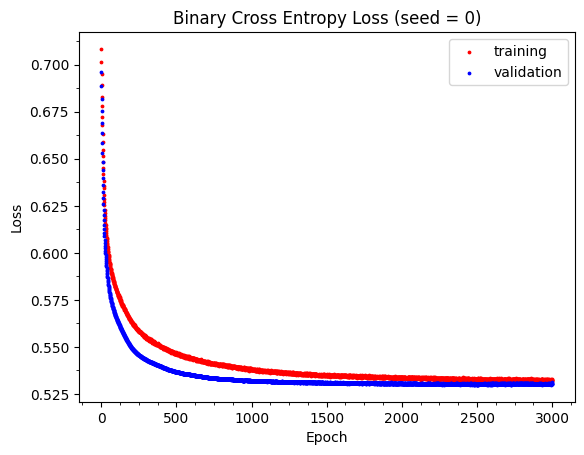

In [29]:
# Plot loss
fig, ax = plt.subplots()

x_vals = np.linspace(1,epochs,epochs)
y1_vals = np.array(train_losses)
y2_vals = np.array(val_losses)

ax.scatter(x_vals, y1_vals, s=3, color="red", label="training")
ax.scatter(x_vals, y2_vals, s=3, color="blue", label="validation")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
ax.set_title("Binary Cross Entropy Loss (seed = {})".format(seed))

ax.xaxis.set_major_locator(MultipleLocator(500))
ax.xaxis.set_minor_locator(MultipleLocator(500/4))
ax.yaxis.set_minor_locator(MultipleLocator(0.05/4))

plt.savefig("dnn_plots/medium/dnn_loss_medium_seed{}.png".format(seed),dpi=200)

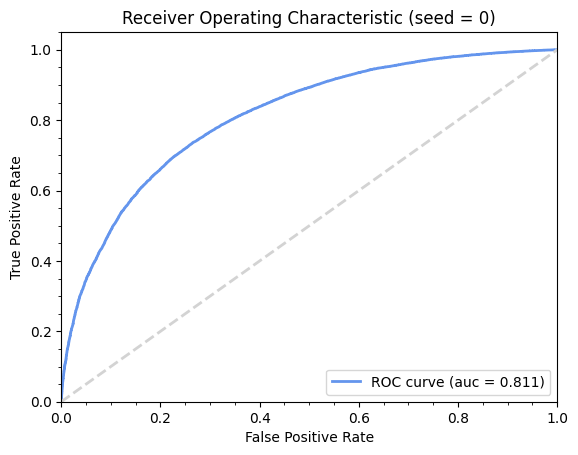

In [30]:
# Plot ROC Curve
model.eval()

# Disable gradient calculation
with torch.no_grad():
    # Forward pass to generate predictions
    y_pred_test = model(X_test)

# Compute fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test.cpu(), y_pred_test.cpu())

# Compute ROC area under the curve
roc_auc = auc(fpr, tpr)

# Plot ROC curve
fig, ax = plt.subplots()

ax.plot(fpr, tpr, color='cornflowerblue', lw=2, label='ROC curve (auc = %0.3f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='lightgray', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (seed = {})'.format(seed))
ax.legend(loc="lower right")

ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_minor_locator(MultipleLocator(0.2/4))
ax.yaxis.set_minor_locator(MultipleLocator(0.2/4))

plt.savefig("dnn_plots/medium/dnn_roc_curve_medium_seed{}.png".format(seed),dpi=200)
plt.show()

In [76]:
# Signal Efficiency and Background Rejection
print("Signal Efficiency: {}, Background Rejection: {}".format(tpr[16619],fpr[16619])) # 95%
print("Signal Efficiency: {}, Background Rejection: {}".format(tpr[14737],fpr[14737])) # 90%
print("Signal Efficiency: {}, Background Rejection: {}".format(tpr[4512],fpr[4512])) # 50%

Signal Efficiency: 0.9500590453697002, Background Rejection: 0.6501733845408106
Signal Efficiency: 0.9000038093786903, Background Rejection: 0.5143741377381706
Signal Efficiency: 0.5002857034017751, Background Rejection: 0.10473917744882359


In [77]:
# Save tpr and fpr scores into a csv file (want to plot all mass points together for comparison)
tpr = np.array(tpr)
fpr = np.array(fpr)

# File path to save the CSV file
csv_file_path = "medium_dnn_roc.csv"

# Column titles
column_titles = "tpr,fpr"

# Save the arrays into a single CSV file
np.savetxt(csv_file_path, np.column_stack((tpr.flatten(), fpr.flatten())), delimiter=',',header=column_titles)

In [79]:
# Inverse Transform the scaled data
df_unscaled = pipeline.inverse_transform(X_test.cpu())
eventNumber_test = X_test_temp.cpu()[:,-1].reshape(-1,1)
X_unscaled = np.hstack((df_unscaled,eventNumber_test))
X_unscaled = np.nan_to_num(X_unscaled, nan=-999)

keys = ['deltaR_top_WfromH',
    'WfromH_mass_fitted_NOSYS',
    'MET_phi_NOSYS',
    'deltaR_WfromTop_WfromH',
    'Hp_mass_fitted_NOSYS',
    'deltaR_WfromH_bjet1',
    'deltaR_Hp_WfromH',
    'top_mass_fitted_NOSYS',
    'top_pt_fitted_NOSYS',
    'Hp_pt_fitted_NOSYS',
    'deltaR_top_Wb_nonTop',
    'A_mass_fitted_NOSYS',
    'Wb_nonTop_pt_fitted_NOSYS',
    'lepton_pt_NOSYS',
    'deltaR_bjet1_bjet2',
    'ljet2_pt_NOSYS',
    'ljet1_pt_NOSYS',
    'bjet1_pt_NOSYS',
    'WfromH_pt_fitted_NOSYS',
    'Wb_nonTop_mass_fitted_NOSYS',
    'EventNumber']

temp = X_unscaled.transpose()

test_events = {}
i = 0
for key in keys:
    test_events[key] = temp[i]
    i += 1

In [80]:
# Save DNN Scores (train and validation) as well as top 20 variables
model.eval()

# Disable gradient calculation
with torch.no_grad():
    # Forward pass to generate predictions
    y_pred_test = model(X_test)
    y_pred_train = model(X_train)

# Validation Scores
predictions_test = np.concatenate(y_pred_test.cpu().numpy())
truth_test = np.concatenate(y_test.cpu().numpy())

# Training Scores
predictions_train = np.concatenate(y_pred_train.cpu().numpy())
truth_train = np.concatenate(y_train.cpu().numpy())

# Creating Lists to store the signal and ttbar predictions (train and validation)
sig_predictions_test = []
ttbar_predictions_test = []
sig_predictions_train = []
ttbar_predictions_train = []

# Creating the dictionaries for signal and ttbar information
sig_test = {}
for key in keys:
    sig_test[key] = []

ttbar_test = {}
for key in keys:
    ttbar_test[key] = []

# Loop over truth 
for i in range(len(truth_test)):
    if truth_test[i] == 1: # signal
        sig_predictions_test.append(predictions_test[i])
        for key in keys:
            sig_test[key].append(test_events[key][i])

    if truth_test[i] == 0: # ttbar
        ttbar_predictions_test.append(predictions_test[i])
        for key in keys:
            ttbar_test[key].append(test_events[key][i])

sig_test["predictions"] = sig_predictions_test
ttbar_test["predictions"] = ttbar_predictions_test

for j in range(len(truth_train)):
    if truth_train[j] == 1: # signal
        sig_predictions_train.append(predictions_train[j])

    if truth_train[j] == 0: # ttbar
        ttbar_predictions_train.append(predictions_train[j])

In [81]:
# Convert all values to numpy arrays
for key in sig_test.keys():
    sig_test[key] = np.array(sig_test[key])
    ttbar_test[key] = np.array(ttbar_test[key])

In [82]:
print(len(sig_predictions_test))
print(len(ttbar_predictions_test))

26251
26819


In [83]:
print(len(sig_test["EventNumber"]))
print(len(ttbar_test["EventNumber"]))

26251
26819


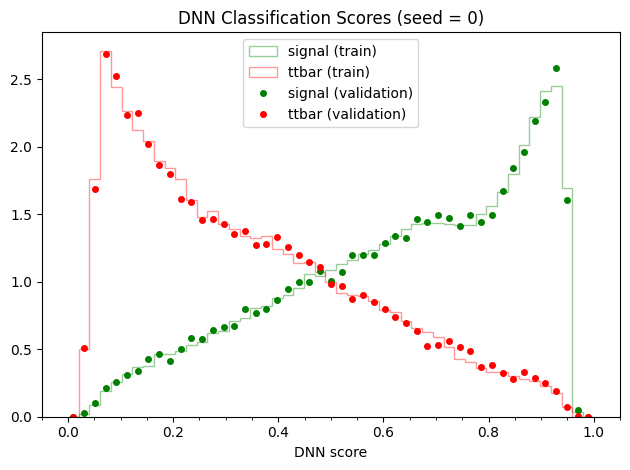

In [84]:
# Plot DNN Scores
fig, ax = plt.subplots()

sig_predictions_test = np.array(sig_predictions_test)
ttbar_predictions_test = np.array(ttbar_predictions_test)

sig_predictions_train = np.array(sig_predictions_train)
ttbar_predictions_train = np.array(ttbar_predictions_train)

bin_list = np.linspace(0,1,50)

def histogram_heights_centers(predictions, bin_list):
    """
    Computes the bin centers and the heights for the predictions
    """
    counts, edges = np.histogram(predictions, bins=bin_list)
    bin_centers = (bin_list[:-1] + bin_list[1:]) / 2
    # Normalize
    bin_width = edges[1] - edges[0]
    bin_heights = counts / (len(predictions) * bin_width)

    return bin_centers, bin_heights

sig_bin_centers, sig_bin_heights = histogram_heights_centers(sig_predictions_test,bin_list)
ttbar_bin_centers, ttbar_bin_heights = histogram_heights_centers(ttbar_predictions_test,bin_list)

ax.hist(sig_predictions_train,bins=bin_list,histtype="step",color="green",density=True, alpha=0.4, label="signal (train)")
ax.hist(ttbar_predictions_train,bins=bin_list,histtype="step",color="red",density=True,alpha=0.4, label="ttbar (train)")
ax.plot(sig_bin_centers, sig_bin_heights, marker="o", markersize=4, linestyle="None", color="green",label="signal (validation)")
ax.plot(ttbar_bin_centers, ttbar_bin_heights, marker="o", markersize=4, linestyle="None", color="red", label="ttbar (validation)")

ax.set_xlabel("DNN score")
ax.set_title("DNN Classification Scores (seed = {})".format(seed))
ax.legend(loc="upper center")

ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_minor_locator(MultipleLocator(0.2/4))
ax.yaxis.set_minor_locator(MultipleLocator(2/4))

fig.tight_layout()
fig.savefig("dnn_plots/medium/dnn_score_medium_seed{}.png".format(seed),dpi=200)

In [88]:
# Examine the variables for different ranges of prediction

# first region: 0 - 0.3
sig_mask1 = sig_predictions_test < 0.3
ttbar_mask1 = ttbar_predictions_test < 0.3
sig_region1 = {key: value[sig_mask1] for key, value in sig_test.items()}
ttbar_region1 = {key: value[ttbar_mask1] for key, value in ttbar_test.items()}

# second region: 0.3 - 0.6
condition1_sig = sig_predictions_test >= 0.3
condition2_sig = sig_predictions_test <= 0.6

condition1_ttbar = ttbar_predictions_test >= 0.3
condition2_ttbar = ttbar_predictions_test <= 0.6

sig_mask2 = condition1_sig & condition2_sig
ttbar_mask2 = condition1_ttbar & condition2_ttbar
sig_region2 = {key: value[sig_mask2] for key, value in sig_test.items()}
ttbar_region2 = {key: value[ttbar_mask2] for key, value in ttbar_test.items()}

# third region: 0.6 - 1
sig_mask3 = sig_predictions_test > 0.6
ttbar_mask3 = ttbar_predictions_test > 0.6
sig_region3 = {key: value[sig_mask3] for key, value in sig_test.items()}
ttbar_region3 = {key: value[ttbar_mask3] for key, value in ttbar_test.items()}

In [89]:
# Create a ROOT file. Each region is a separate branch.
with up.recreate("DNN_medium_test.root") as root_file:
    # Save each region as a separate TTree
    root_file["sig_region1"] = sig_region1
    root_file["ttbar_region1"] = ttbar_region1
    root_file["sig_region2"] = sig_region2
    root_file["ttbar_region2"] = ttbar_region2
    root_file["sig_region3"] = sig_region3
    root_file["ttbar_region3"] = ttbar_region3

In [90]:
def binary_accuracy(preds, y, threshold):
    # Round predictions based on threshold
    rounded_preds = []

    # Loop over all predictions
    for i in range(len(preds)):
        if preds[i] >= threshold: # classify as signal
            rounded_preds.append(1)
        if preds[i] < threshold: # classify as ttbar
            rounded_preds.append(0)
    
    # Convert rounded predictions and true labels to integers (0 or 1)
    correct = (rounded_preds == y) 
    
    # Calculate accuracy
    accuracy = correct.sum() / len(correct)
    
    return accuracy

In [91]:
def find_best_threshold(preds, y):
    best_threshold = 0
    best_accuracy = 0

    # Loop through threshold values from 0 to 1
    for threshold in range(0, 101):  # Threshold values from 0 to 1 with a step of 0.01
        threshold /= 100.0  # Convert threshold to a value between 0 and 1
        accuracy = binary_accuracy(preds, y, threshold)
        
        # Update best threshold and accuracy if the current accuracy is better
        if accuracy > best_accuracy:
            best_threshold = threshold
            best_accuracy = accuracy
    
    return best_threshold, best_accuracy

In [92]:
# Find the best threshold and its corresponding accuracy
best_threshold, best_accuracy = find_best_threshold(predictions_test, truth_test)
print("Best Threshold:", best_threshold)
print("Best Accuracy:", best_accuracy)

Best Threshold: 0.48
Best Accuracy: 0.7352930092330884
